In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os

In [51]:
data_folder = r"C:\Users\Mukta\Desktop\MODULE 1\project sap\data"
all_data = {}

for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        company_name = file.split('.')[0]
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        all_data[company_name] = df

print("Companies loaded:", list(all_data.keys()))

Companies loaded: ['ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO']


In [53]:
def preprocess_data(df, lookback=60, train_ratio=0.8):
    # Use 'Close' prices for prediction
    data = df['Close'].values.reshape(-1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences for LSTM
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Split into training and testing sets
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

# Preprocess data for all companies
preprocessed_data = {}
for company, df in all_data.items():
    X_train, X_test, y_train, y_test, scaler = preprocess_data(df)
    preprocessed_data[company] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'scaler': scaler
    }

In [55]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the model for each company
models = {}
for company, data in preprocessed_data.items():
    print(f"Training model for {company}...")
    X_train, y_train = data['X_train'], data['y_train']
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)
    models[company] = model

Training model for ASIANPAINT...
Epoch 1/10


C:\Users\Mukta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0179
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0021
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0016
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0011
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0014
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0014
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0011
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0011
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0010
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0010
Training model for AXISBANK...
Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0195
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0023
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0019
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0016
Epoch 5/10
132/132 ━━━━━━━━

Evaluating model for ASIANPAINT...
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Test RMSE: 43.084215903633044


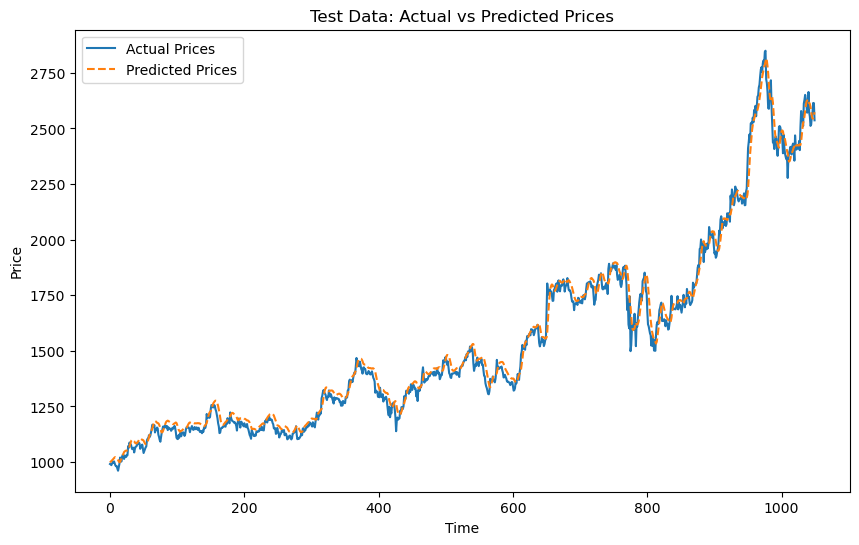

Evaluating model for AXISBANK...
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Test RMSE: 22.547857590273093


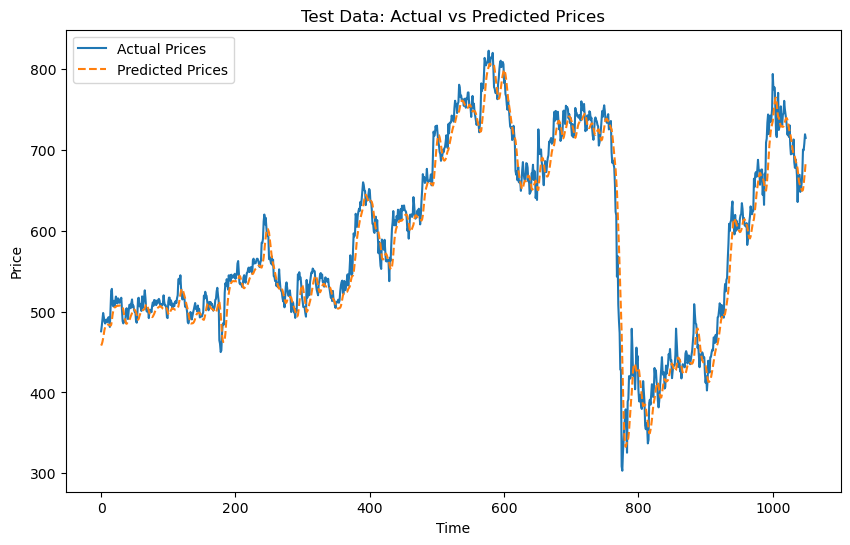

Evaluating model for BAJAJ-AUTO...
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Test RMSE: 100.23109735830725


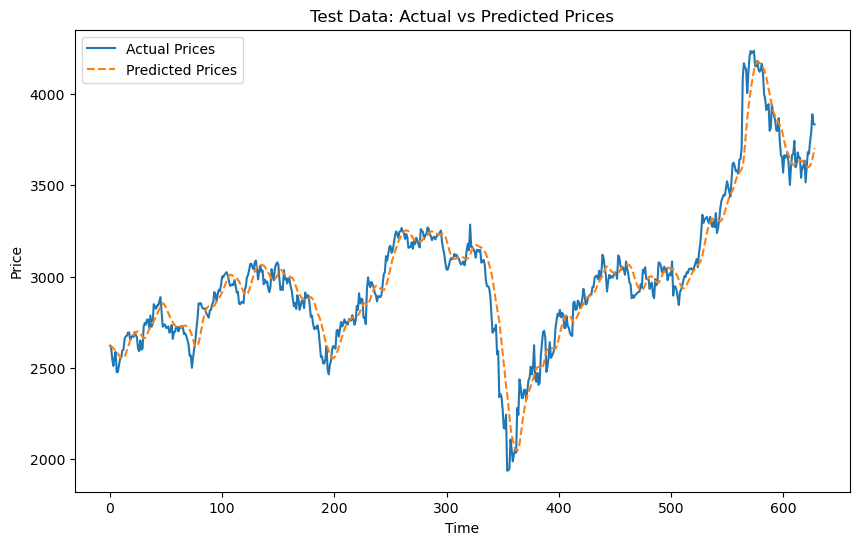

In [57]:
def evaluate_model(model, X_test, y_test, scaler):
    # Predict on test data
    predictions = model.predict(X_test)
    
    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    print(f"Test RMSE: {rmse}")
    
    # Plot test predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices', linestyle='--')
    plt.title('Test Data: Actual vs Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Evaluate the model for each company
for company, model in models.items():
    print(f"Evaluating model for {company}...")
    X_test = preprocessed_data[company]['X_test']
    y_test = preprocessed_data[company]['y_test']
    scaler = preprocessed_data[company]['scaler']
    evaluate_model(model, X_test, y_test, scaler)

In [63]:
# Function to predict future prices
def predict_future_prices(model, scaler, last_sequence, future_days=5):
    predictions = []
    current_sequence = last_sequence[-60:]  # Use the last 60 days of data
    
    for _ in range(future_days):
        # Predict the next day
        next_prediction = model.predict(current_sequence.reshape(1, -1, 1))
        predictions.append(next_prediction[0, 0])
        
        # Update the sequence with the new prediction
        current_sequence = np.append(current_sequence[1:], next_prediction)
    
    # Inverse transform the predictions to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# User input for company name
company_name = input("Enter the company name (e.g., AAPL, GOOGL): ").upper()

if company_name in models:
    # Get the last 60 days of data for the company
    last_sequence = preprocessed_data[company_name]['X_test'][-1]
    scaler = preprocessed_data[company_name]['scaler']
    
    # Predict the next 5 days
    predictions = predict_future_prices(models[company_name], scaler, last_sequence, future_days=5)
    
    # Print the predicted prices
    print(f"Predicted prices for the next 5 days for {company_name}:")
    for i, price in enumerate(predictions, 1):
        print(f"Day {i}: {price[0]:.2f}")
else:
    print(f"Company '{company_name}' not found in the dataset.")

Enter the company name (e.g., AAPL, GOOGL):  AXISBANK


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted prices for the next 5 days for AXISBANK:
Day 1: 684.93
Day 2: 689.80
Day 3: 691.74
Day 4: 692.04
Day 5: 691.39
